In [1]:
# import libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# batch, classes, epochs
batch_size = 32
num_classes = 10
epochs = 10

In [3]:
# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Pre-processing
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(-1,32, 32, 3)  # reshaping for convnet

170500096/170498071 [==============================] - 2s 0us/step


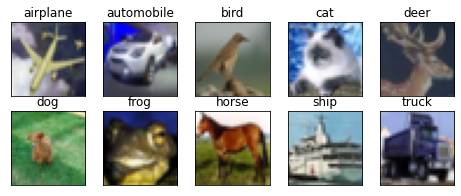

In [4]:
# plotting some random 10 images
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = (features_idx[img_num,::])
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [5]:
# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

##Base Model
First we will train our base model with a simple architecture

In [6]:
# model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [7]:
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

Let's then setup the loss, metrics, and the optimizer. The learning rate is also a hyperparameter you can tune automatically but for now, let's set it at 0.0001.

In [8]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# convert to float, normalise the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [9]:
# train 
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 41s 6ms/step - loss: 2.1719 - accuracy: 0.2047 - val_loss: 2.0485 - val_accuracy: 0.2723
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.0359 - accuracy: 0.2702 - val_loss: 1.9769 - val_accuracy: 0.3003
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.9811 - accuracy: 0.2927 - val_loss: 1.9227 - val_accuracy: 0.3201
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.9295 - accuracy: 0.3124 - val_loss: 1.8794 - val_accuracy: 0.3311
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.8810 - accuracy: 0.3266 - val_loss: 1.8180 - val_accuracy: 0.3524
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.8310 - accuracy: 0.3427 - val_loss: 1.7682 - val_accuracy: 0.3738
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.7945 - accuracy: 0.3571 - val_loss: 1.7290 - val_accura

In [14]:
model_result = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.6490 - accuracy: 0.4190


Result: After 10 epochs, the difference between training and validation accuracy is low but the training is slow as compared to the model with batch normalization.

In [15]:
# Install Keras Tuner
!pip install -q -U keras-tuner

     |████████████████████████████████| 102kB 9.7MB/s 


In [16]:
import kerastuner as kt
import keras

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [17]:
def model_builder(hp):
  '''
  Builds the model and sets up the hyperparameters to tune.

  Args:
    hp - Keras tuner object

  Returns:
    model with hyperparameters to tune
  '''
  hp_filters=hp.Choice(
    'num_filters',
    values=[32, 64],
    default=64)
  
  hP_units=hp.Int(
      'units',
      min_value=32,
      max_value=512,
      step=32,
      default=128)
    
  '''hp_activation=hp.Choice(
        'dense_activation',
        values=['relu', 'tanh', 'sigmoid'],
        default='relu')'''

  hp_dropouts=hp.Choice(
    'dropout',
    values=[0.25, 0.35, 0.5])

# Initialize the Sequential API and start stacking the layers
  model = Sequential()
  
  # Tune the number of units in the first Dense layer
  model.add(
    Conv2D(hp_filters, kernel_size=3,activation='relu',input_shape=x_train.shape[1:]))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(rate=hp_dropouts))
  model.add(Conv2D(hp_filters, 3, activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(rate=hp_dropouts))
  model.add(Flatten())
  model.add(Dense(units=hP_units, activation='relu'))
  model.add(Dropout(rate=hp_dropouts))
  model.add(Dense(num_classes, activation='softmax'))
  # Choose an optimal value between 32-512
  
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.001, 0.0001, 0.00001 or 0.000001
  hp_learning_rate = hp.Choice('learning_rate', values=[ 1e-3, 1e-4, 1e-5,1e-6])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

In [18]:
# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Pre-processing
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(-1,32, 32, 3)  # reshaping for convnet

## Instantiate the Tuner and perform hypertuning

Now that you have the model builder, you can then define how the tuner can find the optimal set of hyperparameters, also called the search strategy. Keras Tuner has [four tuners](https://keras-team.github.io/keras-tuner/documentation/tuners/) available with built-in strategies - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`. 

In this tutorial, you will use the Hyperband tuner. Hyperband is an algorithm specifically developed for hyperparameter optimization. It uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket wherein the algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. You can read about the intuition behind the algorithm in section 3 of [this paper](https://arxiv.org/pdf/1603.06560.pdf).

Hyperband determines the number of models to train in a bracket by computing 1 + log<sub>`factor`</sub>(`max_epochs`) and rounding it up to the nearest integer. You will see these parameters (i.e. `factor` and `max_epochs` passed into the initializer below). In addition, you will also need to define the following to instantiate the Hyperband tuner:

* the hypermodel (built by your model builder function)
* the `objective` to optimize (e.g. validation accuracy)
* a `directory` to save logs and checkpoints for every trial (model configuration) run during the hyperparameter search. If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. To disable this behavior, pass an additional `overwrite=True` argument while instantiating the tuner.
* the `project_name` to differentiate with other runs. This will be used as a subdirectory name under the `directory`.



In [19]:
tuner = kt.Hyperband(
    model_builder,
    max_epochs=5,
    objective='val_accuracy',
    directory='hyperband',
    project_name='cifar10'
)

Let's see a summary of the hyperparameters that you will tune:

In [20]:
# Display hypertuning settings
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_filters (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
units (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Choice)
{'default': 0.25, 'conditions': [], 'values': [0.25, 0.35, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05, 1e-06], 'ordered': True}


You can pass in a callback to stop training early when a metric is not improving. Below, we define an EarlyStopping callback to monitor the validation loss and stop training if it's not improving after 5 epochs.

In [21]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

You will now run the hyperparameter search. The arguments for the search method are the same as those used for tf.keras.model.fit in addition to the callback above. This will take around 5 minutes to run.

In [22]:
# Perform hypertuning
tuner.search(x_train, y_train, epochs=5, validation_split=0.2, callbacks=[stop_early])


Trial 10 Complete [00h 00m 33s]
val_accuracy: 0.3253999948501587

Best val_accuracy So Far: 0.6380000114440918
Total elapsed time: 00h 04m 06s
INFO:tensorflow:Oracle triggered exit


You can get the top performing model with the `get_best_hyperparameters()` method.

In [23]:
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]

print('Optimum no of filter for conv layer is {}'.format(best_hps.get('num_filters')))
print('Optimum no of units in Dense layer is {}'.format(best_hps.get('units')))
print('Optimun Dropout value is {}'.format(best_hps.get('dropout')))
print('Optimum learning rate value is {}'.format(best_hps.get('learning_rate')))

Optimum no of filter for conv layer is 64
Optimum no of units in Dense layer is 448
Optimun Dropout value is 0.35
Optimum learning rate value is 0.001


## Build and train the model

Now that you have the best set of hyperparameters, you can rebuild the hypermodel with these values and retrain it.

In [24]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [25]:
history = h_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5248 - accuracy: 0.4470 - val_loss: 1.2044 - val_accuracy: 0.5820
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2081 - accuracy: 0.5726 - val_loss: 1.0486 - val_accuracy: 0.6398
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0964 - accuracy: 0.6140 - val_loss: 0.9581 - val_accuracy: 0.6658
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0089 - accuracy: 0.6447 - val_loss: 0.9196 - val_accuracy: 0.6834
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9534 - accuracy: 0.6659 - val_loss: 0.8866 - val_accuracy: 0.6949
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9008 - accuracy: 0.6831 - val_loss: 0.8439 - val_accuracy: 0.7118
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8600 - accuracy: 0.6968 - val_loss: 0.8676 - val_accuracy

In [26]:
# evaluate the model on test data
h_model_result = h_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.8239 - accuracy: 0.7158


In [32]:
print('Baseline Model Performance')
print('Loss:', model_result[0])
print('Accuracy:', model_result[1])
print('====================================')
print('Keras Tuner Model Performance')
print('Loss:', h_model_result[0])
print('Accuracy:', h_model_result[1])

Baseline Model Performance
Loss: 1.6489686965942383
Accuracy: 0.4189999997615814
Keras Tuner Model Performance
Loss: 0.8238901495933533
Accuracy: 0.7157999873161316
